In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl


In [3]:
pip install pydot

ERROR! Session/line number was not unique in database. History logging moved to new session 221
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install keras-vis

     --------------------------------------- 12.1/12.1 MB 11.7 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 11.9 MB/s eta 0:00:00
     -------------------------------------- 313.2/313.2 kB 9.8 MB/s eta 0:00:00
     ------------------------------------- 178.9/178.9 kB 10.5 MB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 11.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot  
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot




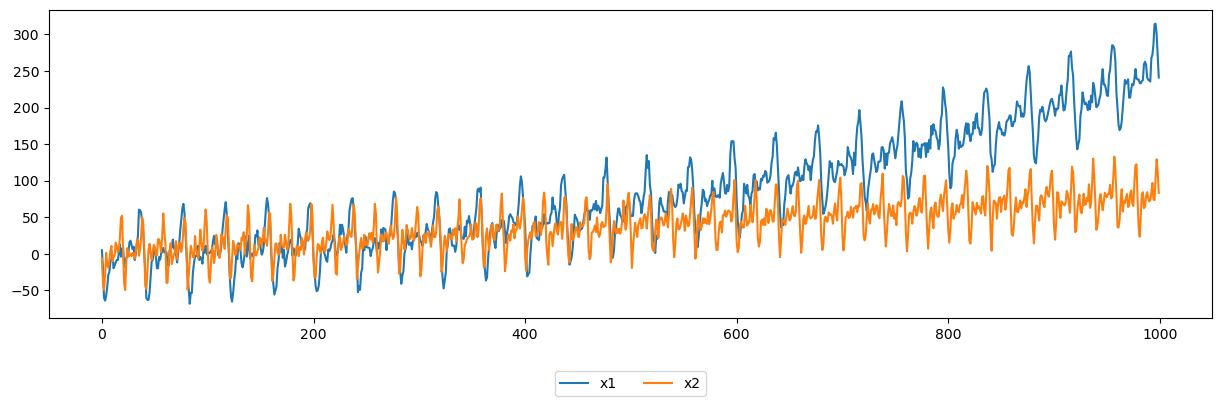

'\nbbox_to_anchor: 범례 상자 위치 조정\nfancybox: True로 설정하면 상자가 둥근 모서리로 표시\nshadow: 범례 상자에 그림자 효과\nncol: 범례의 열 수를 지정 여기서는 2열로 범례 표시\n'

In [3]:
# 데이터 생성
n_=1000
t=np.linspace(0,50*np.pi,n_) 
#임의 시간 추출 0-50pi 까지의 범위를 균일하게 나눈 숫자배열
# n_ 만큼 숫자를 생성

# pattern + trend + noise
x1 = sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0,6,n_)
# 1. 주기가 다른 5개의 사인함수 합: 20sin(it+pi)  (이때 i는 0-4까지의 값, t는 주어짐)
# 2. 추가적으로 0.01t^2 더함
# 3. 평균 0, 표준편차 6의 정규 분포 따르는 랜덤 노이즈

x2= sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0,6,n_)

plt.figure(figsize=(15,4))
plt.plot(range(len(x1)),x1,label='x1') # x축 값으로 사용할 범위를 지정해야 한다.
plt.plot(range(len(x2)),x2,label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.15), fancybox=True, shadow=False,ncol=2)
plt.show()

"""
bbox_to_anchor: 범례 상자 위치 조정
fancybox: True로 설정하면 상자가 둥근 모서리로 표시
shadow: 범례 상자에 그림자 효과
ncol: 범례의 열 수를 지정 여기서는 2열로 범례 표시
"""

In [4]:
# 전처리

train_ratio=0.8
train_len=int(train_ratio*t.shape[0])
print(train_len)

800


In [5]:
# 시계열 데이터를 안정적으로 만들어 모델 학습 시키려면 트랜드제거가 필요하다.
# 여기서는 트랜드의 차수가 알려져 있다 가정하고, 분리된 트랜드 선을 x1,x2에 적합시킨다

x_index=np.array(range(len(t)))

# np.polyfit : 주어진 데이터에 대해 최소 제곱을 갖는 다항식 피팅
x1_trend_p= np.polyfit(x_index[:train_len], x1[:train_len],2)
x2_trend_p= np.polyfit(x_index[:train_len],x2[:train_len],1)
print(x1_trend_p)
print(x2_trend_p)

[ 2.42912674e-04  9.83459868e-03 -3.18355728e+00]
[ 0.07995346 -0.97591371]


In [6]:
x1_trend= (x_index**2)*x1_trend_p[0]+x_index*x1_trend_p[1]+ x1_trend_p[2]
x2_trend= (x_index)*x2_trend_p[0]+x2_trend_p[1]

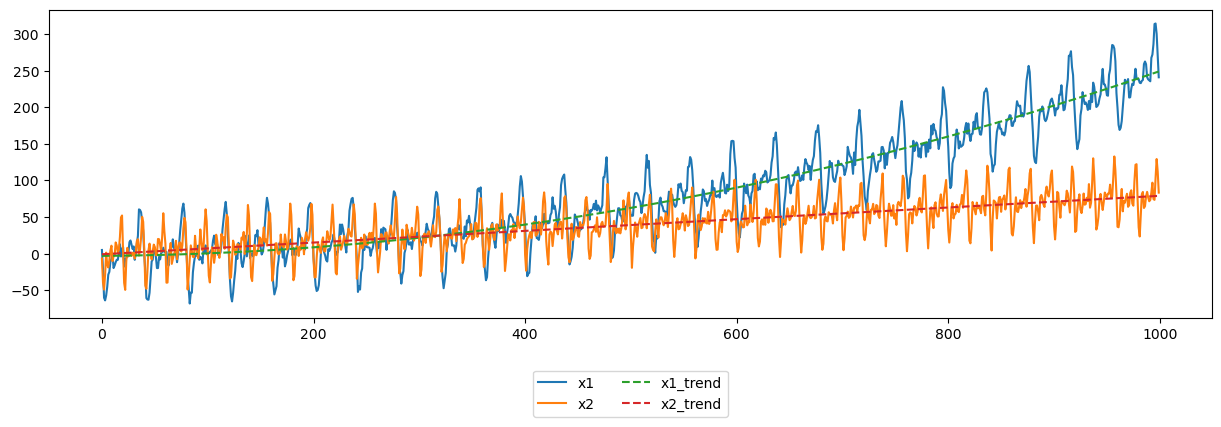

In [7]:
# 트렌드 잘 맞는지 확인
 
plt.figure(figsize=(15,4))
plt.plot(range(len(x1)),x1,label='x1')
plt.plot(range(len(x2)),x2,label='x2')
plt.plot(range(len(x1_trend)),x1_trend,linestyle='--', label='x1_trend')
plt.plot(range(len(x2_trend)),x2_trend,linestyle='--',label='x2_trend')

plt.legend(loc='upper center',bbox_to_anchor=(0.5,-0.15), fancybox=True, shadow=False,ncol=2)
plt.show()

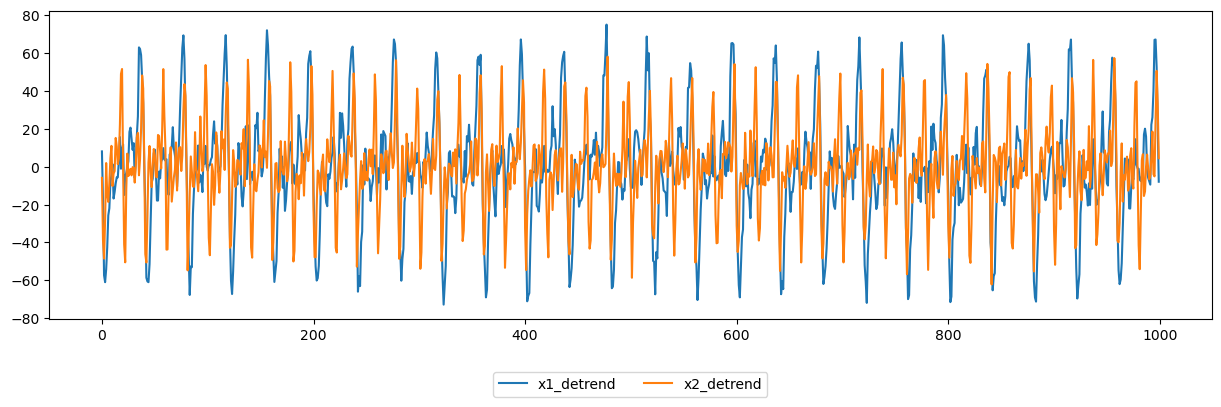

In [8]:
# trend 제거

x1_detrend=x1-x1_trend
x2_detrend=x2-x2_trend

plt.figure(figsize=(15,4))
plt.plot(range(len(x1_detrend)),x1_detrend,label='x1_detrend')
plt.plot(range(len(x2_detrend)),x2_detrend,label='x2_detrend')
plt.legend(loc='upper center',bbox_to_anchor=(0.5,-0.15), fancybox=True, shadow=False,ncol=2)
plt.show()

In [9]:
x_lbl=np.column_stack([x1_detrend,x2_detrend,x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)
# 주어진 배열을 열 방향으로 쌓아서 2차원 배열 생성
# 각 열은 x1_detrend, x2_detrend, x_index, train(1)/test(0) 여부 를 나타낸다

(1000, 4)
[[  8.05285444  -5.90425838   0.           1.        ]
 [-18.1339887  -38.75378002   1.           1.        ]
 [-57.28105414 -48.49967909   2.           1.        ]
 ...
 [ 52.46993172  50.54928366 997.           0.        ]
 [ 21.97606808  33.46411706 998.           0.        ]
 [ -7.9547572    4.42864112 999.           0.        ]]


In [10]:
print(train_len*[1])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [11]:
print(x_index)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [12]:
# normalize

x_train_max=x_lbl[x_lbl[:,3]==1, :2].max(axis=0)
# 배열의 네번째 열이 1인 경우(train set인 경우)
#:2 는 선택된 행 중 0번째 와 1번째 열만 선택, max(axis=0) 이용해 열마다 최댓값 구함

x_train_max=x_train_max.tolist()+[1]*2
print(x_train_max)

# 1 을 뒤에 2개 추가 시킴
# .tolist()  data structure ,array를 list로 만들기 위해

[74.95052000141146, 58.03114155285604, 1, 1]


In [13]:
x_normalize=np.divide(x_lbl,x_train_max)
print(x_normalize)

[[ 1.07442276e-01 -1.01742930e-01  0.00000000e+00  1.00000000e+00]
 [-2.41946136e-01 -6.67810058e-01  1.00000000e+00  1.00000000e+00]
 [-7.64251591e-01 -8.35752629e-01  2.00000000e+00  1.00000000e+00]
 ...
 [ 7.00060943e-01  8.71071675e-01  9.97000000e+02  0.00000000e+00]
 [ 2.93207680e-01  5.76657914e-01  9.98000000e+02  0.00000000e+00]
 [-1.06133449e-01  7.63149061e-02  9.99000000e+02  0.00000000e+00]]


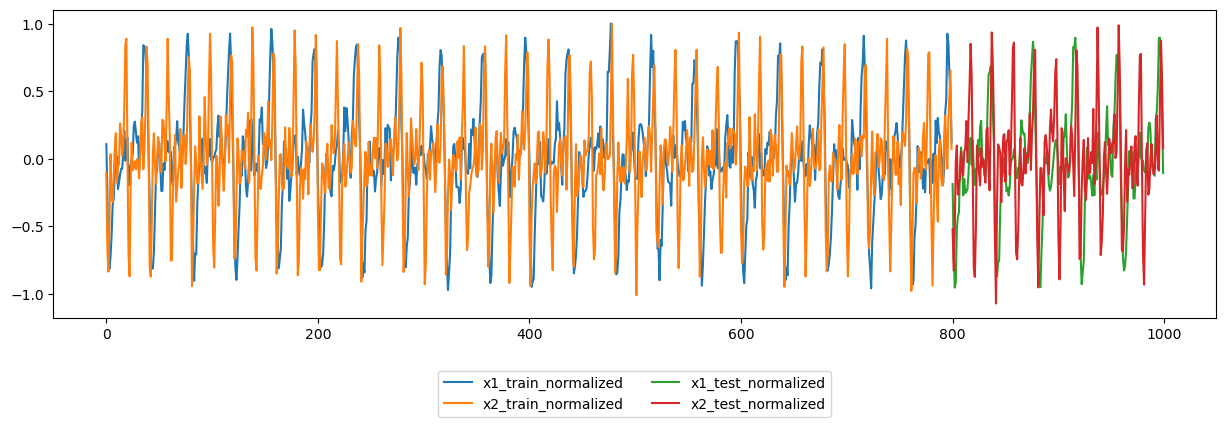

In [14]:
plt.figure(figsize=(15,4))
plt.plot(range(train_len),x_normalize[:train_len,0], label="x1_train_normalized")
plt.plot(range(train_len),x_normalize[:train_len,1],label="x2_train_normalized")
plt.plot(range(train_len, len(x_normalize)),x_normalize[train_len:,0],label="x1_test_normalized")
plt.plot(range(train_len,len(x_normalize)),x_normalize[train_len:,1],label="x2_test_normalized")
# train_len(800) 부터 x_normalize(1000)까지의 정수 범위 생성

plt.legend(loc="upper center",bbox_to_anchor=(0.5,-0.15), fancybox=True,shadow=False,ncol=2)
plt.show()

In [18]:
print(len(x_normalize))

1000


In [21]:
# 절단 truncate
"""
 input window ( length = 200 타임 스텝) 와 output window ( length = 20 타임 스텝)을
 슬라이딩 시키면서 시퀀스를 더 작은 조각으로 자를 것이다.  그리고 이 샘플을 3차원 
 넘파이 배열로 둘 것이다. 


"""
# list.append(element) 즉 append는 리스트 끝에 element를 추가한다.
# range(3) 앞 3 열을 선택
def truncate(x,feature_cols=range(3),target_cols=range(3),label_col=3,train_len=100,test_len=20):
    in_,out_,lbl=[],[],[]
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len),feature_cols].tolist())
        # i 부터 i+train_len까지의 행 선택 후, 그 행들에서 feature_cols에 해당하는 열만 반환
        out_.append(x[(i+train_len):(i+train_len+test_len),target_cols].tolist())
        lbl.append(x[i+train_len,label_col])
    return np.array(in_),np.array(out_),np.array(lbl)

# X_in 의 경우 x_normaliza 에서 앞 3열을 선택 feature col 로 취급
X_in,X_out,lbl=truncate(x_normalize,feature_cols=range(3),target_cols=range(3),label_col=3,train_len=200,test_len=20)
print(X_in.shape,X_out.shape,lbl.shape)
print(X_in)
print()
print("X_out")
print()
print(X_out)
"""
X_in: 781 개 샘플을 포함하고 있고, 각 샘플의 길이 200 타임 스텝, 각 샘플은 3개의
    feature 가지고 있다. (x1,x2,original assigned data position index)
    첫 번째 2가지 feature 들만이 트레이닝에 사용된다
    
X_out: 781개 샘플, 각 샘플 길이 20, 3개 feature, 첫 번째 2가지 feature만이 타겟에 사용
    세 번째 feature은 예측값의 트렌드를 회복시킬 때 사용

라벨: 트레이닝 셋 1, 테스트 셋 0
"""


(781, 200, 3) (781, 20, 3) (781,)
[[[ 1.07442276e-01 -1.01742930e-01  0.00000000e+00]
  [-2.41946136e-01 -6.67810058e-01  1.00000000e+00]
  [-7.64251591e-01 -8.35752629e-01  2.00000000e+00]
  ...
  [ 8.12644762e-01  3.51040599e-01  1.97000000e+02]
  [ 6.28518875e-01  9.14634039e-01  1.98000000e+02]
  [ 2.75489880e-01  6.53177444e-01  1.99000000e+02]]

 [[-2.41946136e-01 -6.67810058e-01  1.00000000e+00]
  [-7.64251591e-01 -8.35752629e-01  2.00000000e+00]
  [-8.13144628e-01 -4.82391452e-01  3.00000000e+00]
  ...
  [ 6.28518875e-01  9.14634039e-01  1.98000000e+02]
  [ 2.75489880e-01  6.53177444e-01  1.99000000e+02]
  [-1.78861676e-01 -3.97362173e-01  2.00000000e+02]]

 [[-7.64251591e-01 -8.35752629e-01  2.00000000e+00]
  [-8.13144628e-01 -4.82391452e-01  3.00000000e+00]
  [-7.22514956e-01  3.26759467e-02  4.00000000e+00]
  ...
  [ 2.75489880e-01  6.53177444e-01  1.99000000e+02]
  [-1.78861676e-01 -3.97362173e-01  2.00000000e+02]
  [-4.61547841e-01 -8.23544585e-01  2.01000000e+02]]

 ...



'\nX_in: 781 개 샘플을 포함하고 있고, 각 샘플의 길이 200 타임 스텝, 각 샘플은 3개의\n    feature 가지고 있다. (x1,x2,original assigned data position index)\n    첫 번째 2가지 feature 들만이 트레이닝에 사용된다\n    \nX_out: 781개 샘플, 각 샘플 길이 20, 3개 feature, 첫 번째 2가지 feature만이 타겟에 사용\n    세 번째 feature은 예측값의 트렌드를 회복시킬 때 사용\n\n라벨: 트레이닝 셋 1, 테스트 셋 0\n'

In [22]:
# 신경망에 입력될 데이터
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(600, 200, 3) (600, 20, 3)
(181, 200, 3) (181, 20, 3)
ERROR! Session/line number was not unique in database. History logging moved to new session 254


In [ ]:
"""
encoder
각 타임 스텝 값으로 encoder LSTM cell에 이전 cell state c 와 hidden state h 넣고
마지막 cell state c, hidden state h 가 생성될 때까지 과정 반복

decoder
encoder로 부터 마지막 cell state c, hidden state h 를 decoder LSTM cell 초기값으로 사용
마지막 encoder의 hidden state  20번 복사, 복사마다 이전 cell state c, hidden state h
를 함께 decoder LSTM cell 에 넣음 
decoder은 모든 20번 타임스텝에 대한 hidden state 출력 hidden state는 최종 결과 출력
위해 dense layer 연결
"""





